- Описаны все найденные датасеты для этой задачи
- Описаны все текущие реализации (в первую очередь доступные в виде открытых решений и репозиториев)
- Реализован подход к обработке данных
- Реализован выбранные вам алгоритм (можно использовать готовые открытые компоненты)
- Реализован механизм разделения на тренировочную и тестовую выборки
- Рассчитаны метрики на тренировочном и тестовом датасете
- Представлен результат в виде репозитория или ноутбука

#Теоретическая часть

## Датасеты найденные для этой задачи
В данной задаче мы будем рассматривать удаление фона у человека, датасетов для этой задачи очень много, но я выделю основные
- [ADE20K](https://groups.csail.mit.edu/vision/datasets/ADE20K/)
- [COCO](https://cocodataset.org/#home)
- [VOC Pascal](http://host.robots.ox.ac.uk/pascal/VOC/)

Также можно упомянуть более мелкие датасеты, собранные отдельными людьми
- [Person Segmentation](https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation?resource=download)(Оказались битые маски)
- [Human Segmentation Dataset](https://github.com/VikramShenoy97/Human-Segmentation-Dataset)
- [Kaggle Human Segmentation](https://www.kaggle.com/datasets/soumikrakshit/human-segmentation)

Также есть несколько закрытых датасетов
- [Human Contour Segmentation And Keypoints](https://maadaa.ai/dataset/single-person-portrait-matting-dataset/)
- [Single Person Portrait Matting Dataset](https://maadaa.ai/dataset/human-contour-segmentation-and-keypoints/)
- [Supervisely dataset](https://hackernoon.com/releasing-supervisely-person-dataset-for-teaching-machines-to-segment-humans-1f1fc1f28469)


##Основные подходы к решению задачи
Так как задача удаления заднего плана, сводиться к обнаружению и классификации контуров, мы можем расматривать более общую задачу.
- [Mask R-CNN](https://pytorch.org/vision/stable/_modules/torchvision/models/detection/mask_rcnn.html)
- [DeepLabV3](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)
- [U2-Net](https://github.com/xuebinqin/U-2-Net)
- [Pixelib](https://github.com/ayoolaolafenwa/PixelLib)
- [UPerNet](https://github.com/CSAILVision/unifiedparsing)
- [HRNet](https://github.com/HRNet/HRNet-Semantic-Segmentation)

Остальные решения не дают нужного качества распознавания, либо являются  неприменимыми для широкого пользования

#Практическая часть

In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
import fnmatch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/VikramShenoy97/Human-Segmentation-Dataset

Cloning into 'Human-Segmentation-Dataset'...
remote: Enumerating objects: 596, done.
remote: Total 596 (delta 0), reused 0 (delta 0), pack-reused 596
Receiving objects: 100% (596/596), 13.60 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
mask_path = "/content/Human-Segmentation-Dataset/Ground_Truth"
image_path = "/content/Human-Segmentation-Dataset/Training_Images"

In [ ]:
class My_Dataset(Dataset):
    def __init__(self, images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return  len(fnmatch.filter(os.listdir(self.masks_directory), '*.png'))

    def __getitem__(self, idx):
        idx = str(idx+1) if idx != 289 else "300"
        image_filename = idx + '.jpg'
        image = Image.open(os.path.join(self.images_directory,image_filename)).convert("RGB")
        mask_filename = idx + ".png"
        mask = Image.open(os.path.join(self.masks_directory,mask_filename)).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = My_Dataset(image_path,mask_path,preprocess)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [ ]:
model = deeplabv3_resnet101(pretrained=True, progress=True)
model.classifier = DeepLabHead(2048, 3)
model.train()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
from torch.cuda import device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 1
train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def train(train_loader, model, criterion, optimizer, epoch,):
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        output = model(images)["out"]
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed May  4 16:32:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    62W / 149W |   6288MiB / 11441MiB |     46%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
metric_monitor = MetricMonitor()
model.train()
model.to(device)
for epoch in range(1, epochs + 1):
        train(train_loader, model, criterion, optimizer, epoch)

  0%|          | 0/58 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 1. Train.      Loss: -2.862: 100%|██████████| 58/58 [01:09<00:00,  1.20s/it]


In [ ]:
model.eval()
with torch.no_grad():
    output = model(preprocess(Image.open("/content/Human-Segmentation-Dataset/Training_Images/288.jpg").convert("RGB")).unsqueeze(0).to(device))['out'][0]
output_predictions = output.argmax(0)


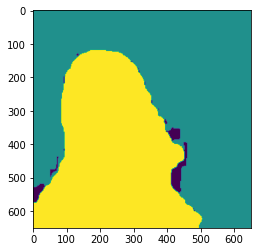

In [ ]:
plt.imshow(Image.fromarray(output_predictions.byte().cpu().numpy()).resize(Image.open("/content/Human-Segmentation-Dataset/Training_Images/288.jpg").convert("RGB").size))

In [ ]:
import matplotlib.pyplot as plt

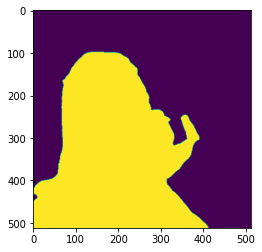

In [ ]:
plt.imshow(Image.open(mask_path+"/288.png").resize((512,512)))

In [ ]:
def delete_bg(im,pred,cls):
    res= np.full(im.shape,(0,0,0))
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
              if(pred[i][j] == cls):
                res[i][j] = im[i][j]
    return res

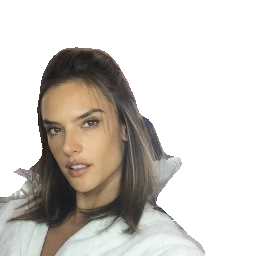

In [ ]:
cv2_imshow(delete_bg(cv2.resize(cv2.imread(image_path+"/288.jpg"),(256,256)),output_predictions.cpu().numpy(),15))

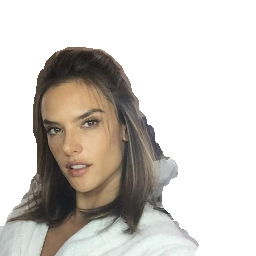

In [ ]:
cv2_imshow(delete_bg(cv2.resize(cv2.imread(image_path+"/288.jpg"),(256,256)),output_predictions,2))

In [ ]:
loss = nn.MSELoss()
all_mse = 0
model.eval()
for item,label in tqdm(train_dataset):
    item = item.to(device)
    label = label.to(device)
    with torch.no_grad():
        pred = model(item.unsqueeze(0))
    all_mse += float(loss(label,item))
print(f"\n MSE на тренировачном датасете {all_mse/len(train_dataset)}")

100%|██████████| 232/232 [00:38<00:00,  6.09it/s]


 MSE на тренировачном датасете 6.631340025827803


In [ ]:
loss = nn.MSELoss()
all_mse = 0
model.eval()
for item,label in tqdm(test_dataset):
    item = item.to(device)
    label = label.to(device)
    with torch.no_grad():
        pred = model(item.unsqueeze(0))
    all_mse += float(loss(label,item))
print(f"\n MSE на тестовом датасете {all_mse/len(test_dataset)}")

100%|██████████| 58/58 [00:09<00:00,  6.03it/s]


 MSE на тестовом датасете 6.378583632666489
